In [9]:
'''
@Author: Stefan Angelov
@Created: 04/23/2021
@Purpose: Predicting the air pollution
'''
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error,  mean_absolute_error
import os


In [32]:
def fit_LSTM(scaled_train_data, time_steps, n_features, batch_size = 6, activation = 'relu', epochs = 10, verbose=0):
    # define generator object to produce batches for training/validation.
    generator = TimeseriesGenerator(data = scaled_train_data, targets = scaled_train_data, length = time_steps, batch_size = batch_size)

    model = Sequential()
    model.add(LSTM(units = 200, activation = activation, input_shape = (time_steps, n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit_generator(generator, epochs = epochs, verbose=verbose)
    
    return model

In [33]:
def predict_LSTM(scaled_train_data, scaler, train_data, test_data, time_steps, n_features, lstm_model):
    
    pred_list = []
    batch = scaled_train_data[-time_steps:].reshape(1, time_steps, n_features)
    for i in range(time_steps):
        pred_list.append(lstm_model.predict(batch)[0])
        batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis = 1)
    # creating dataframe of predicted values
    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=test_data.index, columns = ['Predictions'])
    # plotting the results
    plt.figure(figsize = (20, 5))
    plt.plot(train_data.index, train_data, label = 'Train')
    plt.plot(test_data.index, test_data, label = 'Test')
    plt.plot(df_predict.index, df_predict, label = 'Prediction')
    plt.legend(loc='best', fontsize='xx-large')
    # print pollutant name
    print('\nPredictions of ',train_data.columns.values[0])
    plt.show()
    
    return df_predict

In [34]:
def evaluate_LSTM(actual, predicted):
    # print pollutant name
    print('\nEvaluation of ',actual.columns.values[0])
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
#     print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 4)))
#     print('The Mean Absolute Error of the forecasts is {}'.format(round(mae, 4)))
    print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse,4)))
    
    # save results locally
    if not os.path.exists('result'): os.mkdir('result')
    if not os.path.exists('result/lstm.csv'):
        # create result dataframe for storing evaluation results(initialized with zeros)
        pd.DataFrame(data = {'EM' : ['mse','mae','rmse'] , 'PM2.5': [0.0,0.0,0.0], 'PM10': [0.0,0.0,0.0],
                                  'SO2': [0.0,0.0,0.0], 'NO2': [0.0,0.0,0.0],
                                  'CO': [0.0,0.0,0.0], 'O3': [0.0,0.0,0.0],


                            }).to_csv('result/lstm.csv',index = False)
        
    # read the lstm.csv file
    result = pd.read_csv('result/lstm.csv', dtype = {'EM':str})
    # set index as EM (Evaluation Matrix)
    result.set_index('EM', inplace = True)
    # write all the results
    result[actual.columns.values[0]]['mse'] = round(mse, 4)
    result[actual.columns.values[0]]['mae'] = round(mae, 4)
    result[actual.columns.values[0]]['rmse'] = round(rmse, 4)
    # save the file after writing
    result.to_csv('result/lstm.csv')
    # display successfull write message
#     print('\nResults for {} successfully saved to result/lstm.csv'.format(actual.columns.values[0]))

In [35]:
# Scaling Train-Test data
def transform_data(train_data):
    
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    return scaler.transform(train_data), scaler 

In [36]:
# loading the daily data of PM2.5
train_PM25 = pd.read_csv('dataset/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

In [37]:
# transform train_PM25 data
scaled_train_PM25, scaler = transform_data(train_PM25)

In [44]:
# define parameters for the LSTM model
# time_steps: 12 for monthly, 365 for daily data is preffered.
time_steps = 12
# no of units as n_feature: Since we have only one feature so we will take n_feature as 1.
n_feature = 1
# fit the LSTM model
model = fit_LSTM(scaled_train_PM25, time_steps, n_feature)

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '



Predictions of  PM2.5


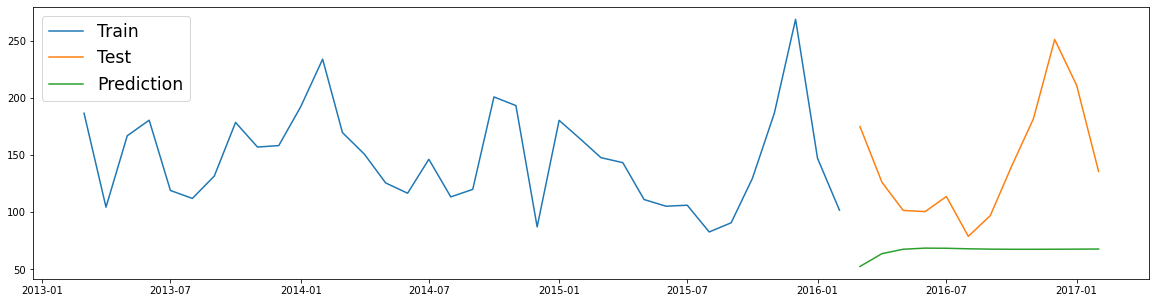

            Predictions
Date-Time              
2016-03-01    52.552807
2016-04-01    63.762035
2016-05-01    67.625120
2016-06-01    68.601893
2016-07-01    68.478427
2016-08-01    68.013178
2016-09-01    67.716486
2016-10-01    67.594861
2016-11-01    67.597407
2016-12-01    67.638029
2017-01-01    67.725691
2017-02-01    67.809414


In [45]:
# Predict PM2.5 using LSTM
predictions = predict_LSTM(scaled_train_PM25, scaler, train_PM25, test_PM25,time_steps, n_feature, model)
print(predictions)

In [40]:
# Plot the predictions for PM2.5 pollutant
evaluate_LSTM(test_PM25, predictions)


Evaluation of  PM2.5
The Root Mean Squared Error of the forecasts is 73.6854


In [41]:
# load all monthly datasets
train_PM25 = pd.read_csv('dataset/monthly/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/monthly/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])
train_PM10 = pd.read_csv('dataset/monthly/train/train_PM10.csv', parse_dates = [0], index_col = [0])
test_PM10 = pd.read_csv('dataset/monthly/test/test_PM10.csv', parse_dates = [0], index_col = [0])
train_SO2 = pd.read_csv('dataset/monthly/train/train_SO2.csv', parse_dates = [0], index_col = [0])
test_SO2 = pd.read_csv('dataset/monthly/test/test_SO2.csv', parse_dates = [0], index_col = [0])
train_NO2 = pd.read_csv('dataset/monthly/train/train_NO2.csv', parse_dates = [0], index_col = [0])
test_NO2 = pd.read_csv('dataset/monthly/test/test_NO2.csv', parse_dates = [0], index_col = [0])
train_CO = pd.read_csv('dataset/monthly/train/train_CO.csv', parse_dates = [0], index_col = [0])
test_CO = pd.read_csv('dataset/monthly/test/test_CO.csv', parse_dates = [0], index_col = [0])
train_O3 = pd.read_csv('dataset/monthly/train/train_O3.csv', parse_dates = [0], index_col = [0])
test_O3 = pd.read_csv('dataset/monthly/test/test_O3.csv', parse_dates = [0], index_col = [0])

In [21]:
# apply transformations on all monthly data
scaled_train_PM25, scaler_PM25 = transform_data(train_PM25)
scaled_train_PM10, scaler_PM10 = transform_data(train_PM10)
scaled_train_SO2, scaler_SO2 = transform_data(train_SO2)
scaled_train_NO2, scaler_NO2 = transform_data(train_NO2)
scaled_train_CO, scaler_CO = transform_data(train_CO)
scaled_train_O3, scaler_O3 = transform_data(train_O3)

In [22]:
# define parameters for the LSTM model (After some manual hyperparameter tuning)
time_steps = 12
n_feature = 1
epochs = 350
# create list for test data
list_test = [test_PM25, test_PM10, test_SO2, test_NO2, test_CO, test_O3]
# create list for train data
list_train = [train_PM25, train_PM10, train_SO2, train_NO2, train_CO, train_O3]
# create list for scaled train data
list_scaled_train = [scaled_train_PM25, scaled_train_PM10, scaled_train_SO2, scaled_train_NO2, scaled_train_CO, scaled_train_O3]
# create list of all scalers
list_scaler = [scaler_PM25, scaler_PM10, scaler_SO2, scaler_NO2, scaler_CO, scaler_O3]
# create list for storing models
list_models = []
# fit LSTM model to all the data
for i in range(len(list_scaled_train)):
    print('\nFitting LSTM on ',list_train[i].columns.values[0])
    list_models.append(fit_LSTM(list_scaled_train[i], time_steps, n_feature, epochs = epochs))


Fitting LSTM on  PM2.5
Epoch 1/350


/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


4/4 [==============================] - 1s 13ms/step - loss: 0.1409
Epoch 2/350
4/4 [==============================] - 0s 13ms/step - loss: 0.1107
Epoch 3/350
4/4 [==============================] - 0s 12ms/step - loss: 0.0336
Epoch 4/350
4/4 [==============================] - 0s 13ms/step - loss: 0.0561
Epoch 5/350
4/4 [==============================] - 0s 12ms/step - loss: 0.0517
Epoch 6/350
4/4 [==============================] - 0s 12ms/step - loss: 0.0702
Epoch 7/350
4/4 [==============================] - ETA: 0s - loss: 0.054 - 0s 12ms/step - loss: 0.0637
Epoch 8/350
4/4 [==============================] - 0s 12ms/step - loss: 0.0829
Epoch 9/350
4/4 [==============================] - 0s 12ms/step - loss: 0.0863
Epoch 10/350
4/4 [==============================] - 0s 12ms/step - loss: 0.0733
Epoch 11/350
4/4 [==============================] - 0s 11ms/step - loss: 0.0500
Epoch 12/350
4/4 [==============================] - 0s 12ms/step - loss: 0.0511
Epoch 13/350
4/4 [===================


Predictions of  PM2.5


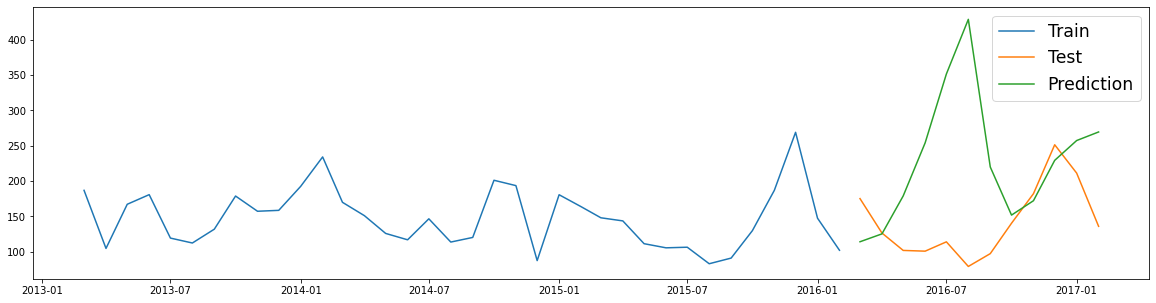


Predictions of  PM10


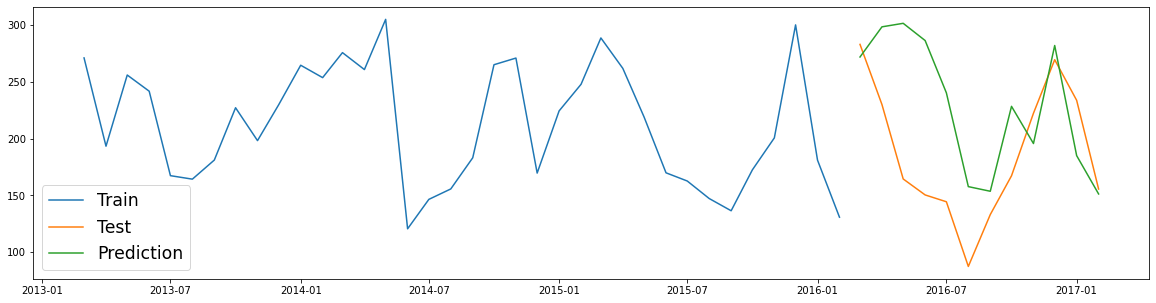


Predictions of  SO2


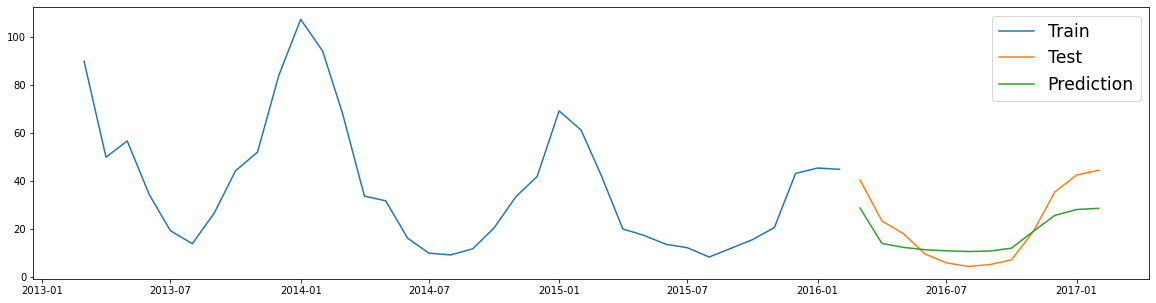


Predictions of  NO2


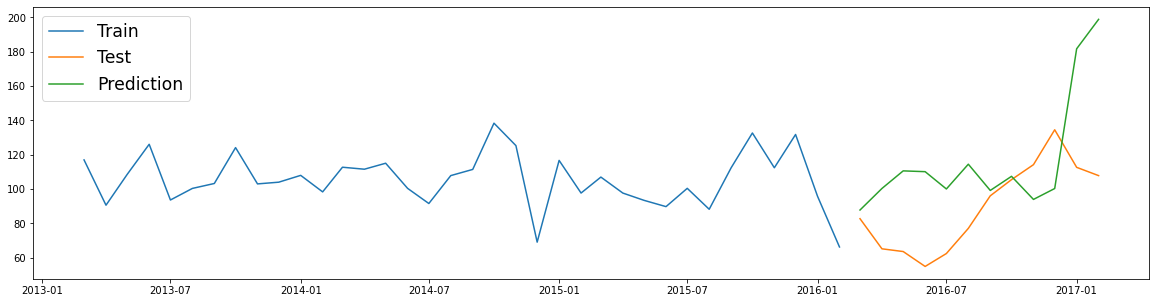


Predictions of  CO


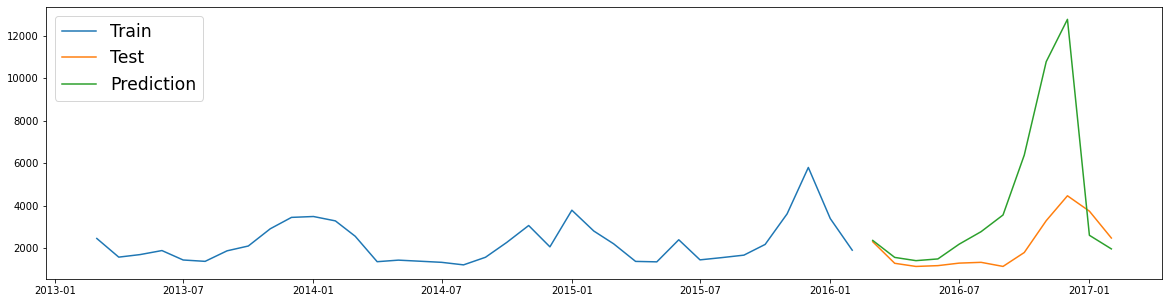


Predictions of  O3


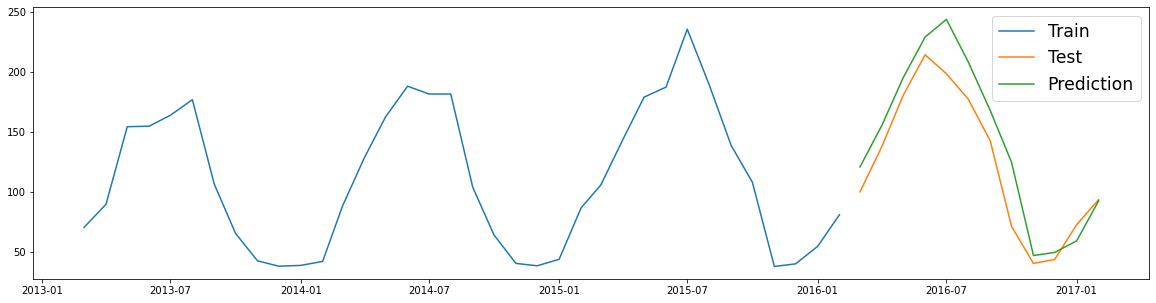

In [23]:
# Predict all the pollutants
list_predictions = [predict_LSTM(list_scaled_train[i], list_scaler[i],\
                                list_train[i], list_test[i],time_steps,\
                                n_feature, list_models[i]) \
                   for i in range(len(list_scaled_train))]


In [24]:
# Evaluate all the models
for i in range(len(list_predictions)):
    # Evaluate each model
    evaluate_LSTM(list_test[i], list_predictions[i])
# The predictions given by the model are roughly 144 ug/m3 off ( microgram / cubic meter) , on average. Given that the average value of PM2.5 is 83 ug/m3 ( microgram / cubic meter) , this model clearly isn’t performing well. Fortunately, we can do some feature engineering and then test out some other models.


Evaluation of  PM2.5
The Root Mean Squared Error of the forecasts is 143.8644

Evaluation of  PM10
The Root Mean Squared Error of the forecasts is 72.7839

Evaluation of  SO2
The Root Mean Squared Error of the forecasts is 8.8157

Evaluation of  NO2
The Root Mean Squared Error of the forecasts is 44.6856

Evaluation of  CO
The Root Mean Squared Error of the forecasts is 3608.8788

Evaluation of  O3
The Root Mean Squared Error of the forecasts is 25.7738


In [25]:
# load all monthly datasets
train_PM25 = pd.read_csv('dataset/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])
train_PM10 = pd.read_csv('dataset/daily/train/train_PM10.csv', parse_dates = [0], index_col = [0])
test_PM10 = pd.read_csv('dataset/daily/test/test_PM10.csv', parse_dates = [0], index_col = [0])
train_SO2 = pd.read_csv('dataset/daily/train/train_SO2.csv', parse_dates = [0], index_col = [0])
test_SO2 = pd.read_csv('dataset/daily/test/test_SO2.csv', parse_dates = [0], index_col = [0])
train_NO2 = pd.read_csv('dataset/daily/train/train_NO2.csv', parse_dates = [0], index_col = [0])
test_NO2 = pd.read_csv('dataset/daily/test/test_NO2.csv', parse_dates = [0], index_col = [0])
train_CO = pd.read_csv('dataset/daily/train/train_CO.csv', parse_dates = [0], index_col = [0])
test_CO = pd.read_csv('dataset/daily/test/test_CO.csv', parse_dates = [0], index_col = [0])
train_O3 = pd.read_csv('dataset/daily/train/train_O3.csv', parse_dates = [0], index_col = [0])
test_O3 = pd.read_csv('dataset/daily/test/test_O3.csv', parse_dates = [0], index_col = [0])

In [26]:
# apply transformations on all monthly data
scaled_train_PM25, scaler_PM25 = transform_data(train_PM25)
scaled_train_PM10, scaler_PM10 = transform_data(train_PM10)
scaled_train_SO2, scaler_SO2 = transform_data(train_SO2)
scaled_train_NO2, scaler_NO2 = transform_data(train_NO2)
scaled_train_CO, scaler_CO = transform_data(train_CO)
scaled_train_O3, scaler_O3 = transform_data(train_O3)

In [42]:
# define parameters for the LSTM model (After some manual hyperparameter tuning)
time_steps = 365
n_feature = 1
epochs = 8
# create list for test data
list_test = [test_PM25, test_PM10, test_SO2, test_NO2, test_CO, test_O3]
# create list for train data
list_train = [train_PM25, train_PM10, train_SO2, train_NO2, train_CO, train_O3]
# create list for scaled train data
list_scaled_train = [scaled_train_PM25, scaled_train_PM10, scaled_train_SO2, scaled_train_NO2, scaled_train_CO, scaled_train_O3]
# create list of all scalers
list_scaler = [scaler_PM25, scaler_PM10, scaler_SO2, scaler_NO2, scaler_CO, scaler_O3]
# create list for storing models
list_models = []
# fit LSTM model to all the data
for i in range(len(list_scaled_train)):
    print('\nFitting LSTM on ',list_train[i].columns.values[0])
    list_models.append(fit_LSTM(list_scaled_train[i], time_steps, n_feature, epochs = epochs, verbose=0))


Fitting LSTM on  PM2.5


/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '



Fitting LSTM on  PM10

Fitting LSTM on  SO2

Fitting LSTM on  NO2

Fitting LSTM on  CO

Fitting LSTM on  O3
